In [2]:
import torch
import torch.nn as nn

class Conv1DModel(nn.Module):
    """
    A 1D Convolutional Neural Network for feature extraction or classification.
    """
    def __init__(self, input_channels=1, num_classes=None):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling

        if num_classes:
            self.fc = nn.Linear(64, num_classes)  # Fully connected layer for classification
        else:
            self.fc = None  # No classification layer for feature extraction

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.global_pool(x).squeeze(-1)  # Output feature vector

        if self.fc:
            x = self.fc(x)
        return x

# Example Usage: Initialize the model
model = Conv1DModel(input_channels=1, num_classes=3)  # 3 classes for classification
print(model)

Conv1DModel(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

def preprocess_emg_data(emg_signals, labels, fs=1000):
    """
    Preprocess EMG signals for 1D CNN training.
    
    Parameters:
        emg_signals (list of np.ndarray): List of raw EMG signals.
        labels (list): Corresponding labels for classification.
        fs (int): Sampling frequency (default: 1000 Hz).
    
    Returns:
        DataLoader: Torch DataLoader for training/testing.
    """
    # Normalize EMG signals to range [0, 1]
    emg_signals = [signal / np.max(np.abs(signal)) for signal in emg_signals]

    # Convert to PyTorch tensors
    emg_tensors = [torch.tensor(signal, dtype=torch.float32).unsqueeze(0) for signal in emg_signals]  # Add channel dimension
    label_tensors = torch.tensor(labels, dtype=torch.long)

    # Create TensorDataset
    dataset = TensorDataset(torch.stack(emg_tensors), label_tensors)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Batch size can be adjusted

    return dataloader

# Example Usage: Prepare DataLoader
emg_signals = [np.random.randn(1000) for _ in range(100)]  # Replace with actual EMG data
labels = [np.random.randint(0, 3) for _ in range(100)]     # Replace with actual labels
train_loader = preprocess_emg_data(emg_signals, labels)
print("DataLoader prepared!")

DataLoader prepared!


In [11]:
import torch.optim as optim

def train_cnn(model, dataloader, num_epochs=100, learning_rate=0.001):
    """
    Train the 1D CNN model.
    
    Parameters:
        model (nn.Module): The CNN model.
        dataloader (DataLoader): DataLoader for training data.
        num_epochs (int): Number of epochs for training.
        learning_rate (float): Learning rate for optimizer.
    """
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for signals, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Example Usage: Train the model
model = Conv1DModel(input_channels=1, num_classes=3)  # Reinitialize model
train_cnn(model, train_loader, num_epochs=10)

Epoch 1/10, Loss: 4.4110
Epoch 2/10, Loss: 4.4006
Epoch 3/10, Loss: 4.3589
Epoch 4/10, Loss: 4.3983
Epoch 5/10, Loss: 4.4144
Epoch 6/10, Loss: 4.3985
Epoch 7/10, Loss: 4.3527
Epoch 8/10, Loss: 4.3668
Epoch 9/10, Loss: 4.3689
Epoch 10/10, Loss: 4.3669


In [10]:
def evaluate_cnn(model, dataloader):
    """
    Evaluate the 1D CNN model.
    
    Parameters:
        model (nn.Module): The trained CNN model.
        dataloader (DataLoader): DataLoader for test data.
    
    Returns:
        float: Accuracy of the model on the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for signals, labels in dataloader:
            outputs = model(signals)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Example Usage: Evaluate the model
test_signals = [np.random.randn(1000) for _ in range(20)]  # Replace with actual test EMG signals
test_labels = [np.random.randint(0, 3) for _ in range(20)]  # Replace with actual test labels
test_loader = preprocess_emg_data(test_signals, test_labels)

evaluate_cnn(model, test_loader)

Accuracy: 40.00%


40.0

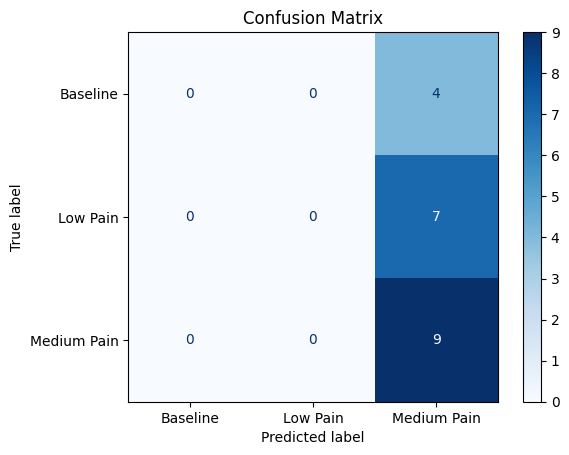

In [8]:
def plot_confusion_matrix(model, dataloader, class_names):
    """
    Compute and plot the confusion matrix for a trained model.
    
    Parameters:
        model (nn.Module): The trained CNN model.
        dataloader (DataLoader): DataLoader containing test data.
        class_names (list): Names of the classes for labeling the confusion matrix.
    """
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for signals, labels in dataloader:
            outputs = model(signals)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=range(len(class_names)))

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Example Usage: Plot Confusion Matrix
test_signals = [np.random.randn(1000) for _ in range(20)]  # Replace with actual test EMG signals
test_labels = [np.random.randint(0, 3) for _ in range(20)]  # Replace with actual test labels
test_loader = preprocess_emg_data(test_signals, test_labels)

class_names = ["Baseline", "Low Pain", "Medium Pain"]  # Update class names if needed
plot_confusion_matrix(model, test_loader, class_names)